In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
train_path = '/Users/viktoriadvornyk/Documents/ML/airbus_ship/airbus-ship-detection/train_v2/'

In [3]:
df = pd.read_csv('train_ship_segmentations_v2.csv')

# EDA

In [4]:
# display the first few rows of the dataset
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
# check the shape of the dataset
print('Dataset shape:', df.shape)

Dataset shape: (231723, 2)


In [6]:
# check the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [7]:
# check for missing values
print('Missing values:')
df.isnull().sum()

Missing values:


ImageId               0
EncodedPixels    150000
dtype: int64

In [8]:
df.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


### Look at one image

In [9]:
df_test = df.loc[df.ImageId == '000194a2d.jpg']
df_test

,ImageId,EncodedPixels
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...


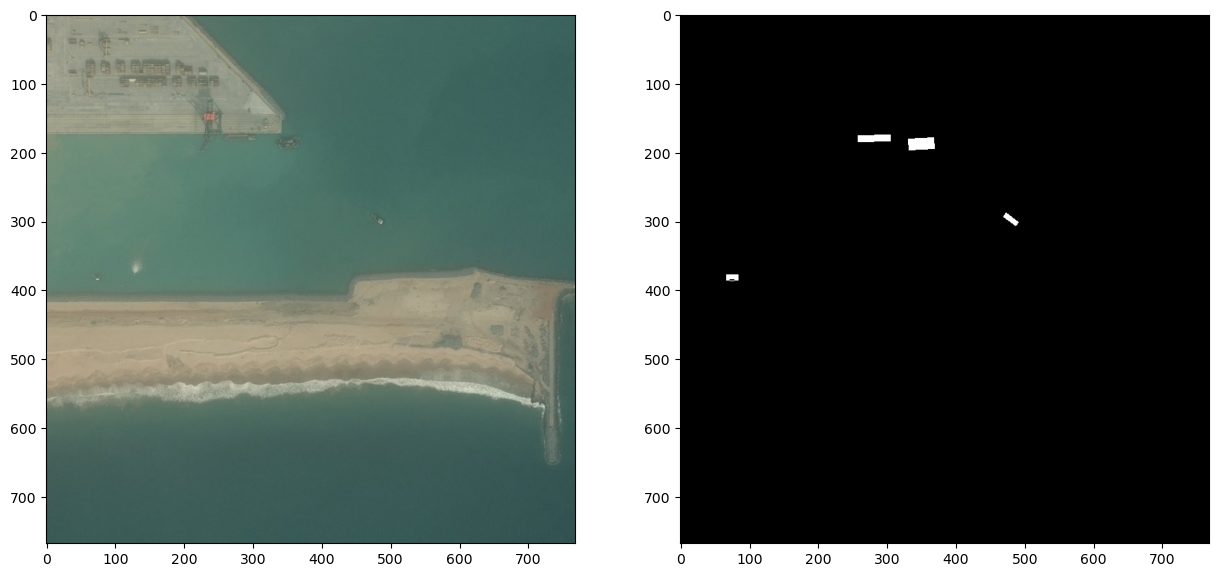

In [10]:
def create_mask(mask, shape):
    # creating a mask based on encoded pixels
    encoded_pixels = mask.split(' ')
    positions = map(int, encoded_pixels[::2])
    lengths = map(int, encoded_pixels[1::2])

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for pos, length in zip(positions, lengths):
        # iterating through positions and lengths to set corresponding values in the mask
        mask[pos:pos + length] = 1

    return mask.reshape(shape)


def display_img_and_masks(image_id, img_shape=(768, 768)):
    # loading the image with the given image_id
    img = cv2.imread(f'{train_path}{image_id}')
    # extracting the encoded pixels for the image
    img_masks = df.loc[df['ImageId'] == image_id, 'EncodedPixels'].tolist()

    # initializing an array to store all the masks
    all_masks = np.zeros(img_shape, dtype=np.uint8)

    for mask in img_masks:
        # checking if the mask is not empty
        if mask == mask:
            # decoding the mask and transposing it
            decoded_mask = create_mask(mask, img_shape).T
            # adding the decoded mask to the array of all masks
            all_masks += decoded_mask

    # creating subplots for the original image and the combined mask
    fig, axarr = plt.subplots(1, 2, figsize=(15, 40))

    # displaying the original image
    axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # displaying the combined mask
    axarr[1].imshow(all_masks, cmap='gray')

    # showing the plot
    plt.show()


display_img_and_masks('000194a2d.jpg')

### Count the occurrences of each image

e6fd0c12e.jpg    15
b2c2f7529.jpg    15
6c06acaa5.jpg    15
56d23b600.jpg    15
5ba9557ef.jpg    15
Name: ImageId, dtype: int64


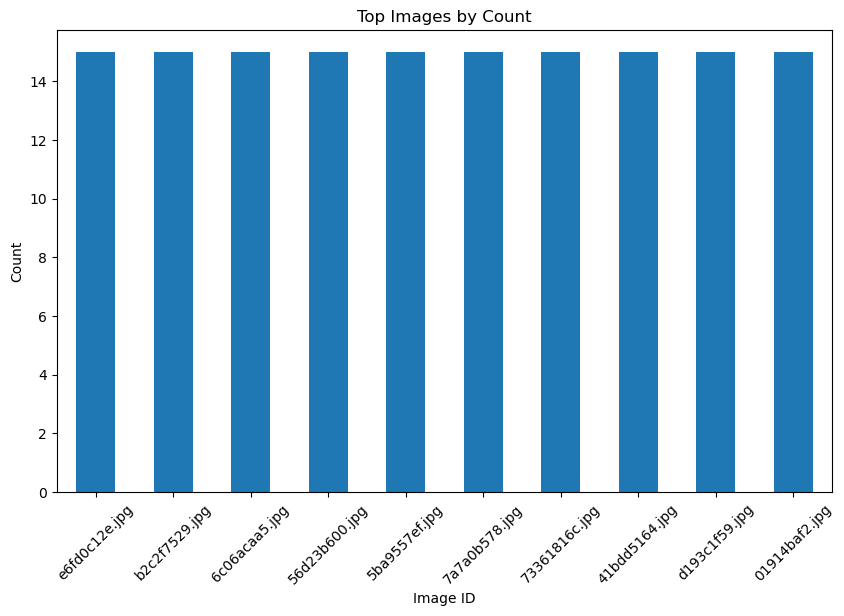

In [11]:
# count the occurrences of each image and sort
image_counts = df['ImageId'].value_counts()
sorted_image_counts = image_counts.sort_values(ascending=False)

top_images = sorted_image_counts.head(5)
print(top_images)

# plot the top images
plt.figure(figsize=(10, 6))
sorted_image_counts.head(10).plot(kind='bar')
plt.title('Top Images by Count')
plt.xlabel('Image ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Missing values

/Users/viktoriadvornyk/opt/anaconda3/lib/python3.9/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


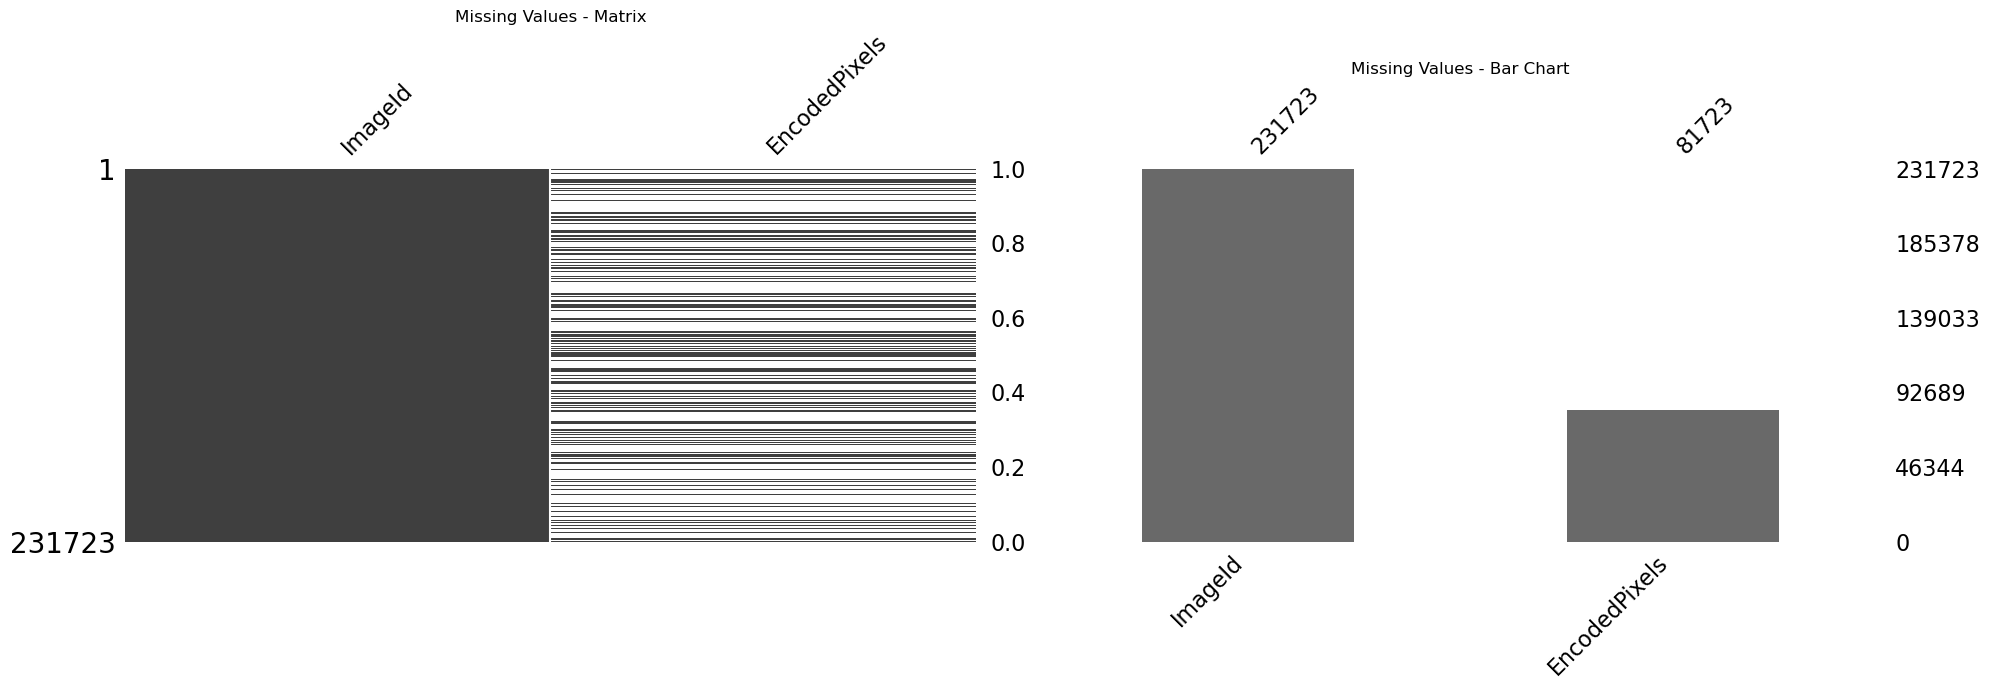

In [12]:
# create subplots for matrix and bar chart visualizations
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# matrix visualization
ax1 = axes[0]
msno.matrix(df, ax=ax1)
ax1.set_title('Missing Values - Matrix')

# bar chart visualization
ax2 = axes[1]
msno.bar(df, ax=ax2)
ax2.set_title('Missing Values - Bar Chart')

plt.tight_layout()
plt.show()

### Distribution of Ship Count

In [13]:
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform('count')
df['ship_count'].describe()

count    231723.000000
mean          1.991796
std           2.466336
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64

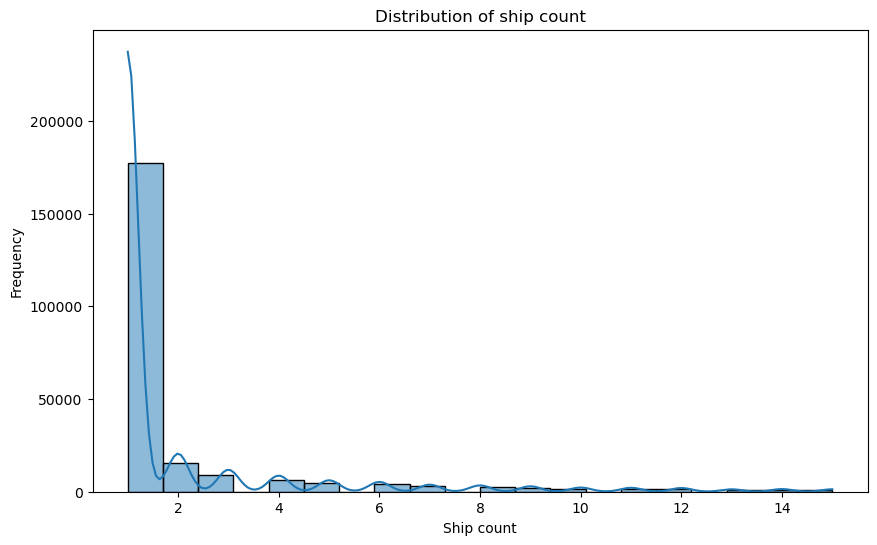

In [14]:
# plot the distribution of ship count
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ship_count', kde=True, bins=20, edgecolor='black')
plt.title('Distribution of ship count')
plt.xlabel('Ship count')
plt.ylabel('Frequency')
plt.show()

# Data Preprocessing

In [15]:
def load_image(image_id, image_size):
    # load and preprocess the image
    image_path = f"{train_path}{image_id}"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = image / 255  # normalize pixel values between 0 and 1
    return image

# example
image_id = "0006c52e8.jpg"
image_size = (256, 256)
image = load_image(image_id, image_size)
# print(image)

In [16]:
def create_mask(encoded_pixels, image_size):
    # Create a mask from the encoded pixels
    mask = np.zeros(image_size, dtype=np.uint8)
    if encoded_pixels is np.nan:
        return mask
    
    encoded_pixels = encoded_pixels.split(' ')
    positions = map(int, encoded_pixels[::2])
    lengths = map(int, encoded_pixels[1::2])
    
    for pos, length in zip(positions, lengths):
        mask[pos : pos + length] = 255 # mark with white mask
    
    return mask

# example
encoded_pixels = '264661 17 265429 33 266197 33 266965 33 267733'
image_size = (256, 256)
mask = create_mask(encoded_pixels, image_size)
print(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
%%time
# preprocess the data
image_ids = df['ImageId'].values #.loc[~df.EncodedPixels.isnull()]
encoded_pixels = df['EncodedPixels'].values

# resize images and normalize pixel values
images = []  # store preprocessed images
masks = []  # store preprocessed masks (labels)
image_size = (16, 16)  # adjust size - the bigger size was harder 

for image_id, encoded_pixel in zip(image_ids, encoded_pixels):
    image = load_image(image_id, image_size)  # function to load and preprocess the image
    mask = create_mask(encoded_pixel, image_size)  # function to create mask from encoded pixels
    images.append(image)
    masks.append(mask)

# convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)
# print(images)
# print(masks)

Premature end of JPEG file


CPU times: user 13min 4s, sys: 44.4 s, total: 13min 48s
Wall time: 14min 56s


In [19]:
# save the arrays to files
np.save('train/images.npy', images)
np.save('train/masks.npy', masks)

In [20]:
# load the arrays from files
images = np.load('images.npy')
masks = np.load('masks.npy')

# print(images)
# print(masks)